<a href="https://colab.research.google.com/github/IA2021UR/trabajo-ia-en-la-comunidad-de-la-rioja-equipo-7/blob/main/ClasificacionImagenesAntiguas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Trabajo final de Inteligencia Artificial: Clasificación de imágenes antiguas**

Hecho por: Ignacio Jorquera Ferrat y Patricia Vallejo Fernández

________________________________________________________________________________

En este notebook se llevará a cabo el desarrollo de un modelo que sea capaz de clasificar una imagen antigua dada, es decir, si es una foto de familia, militar, etc.

En el siguiente notebook, veremos como crear una aplicación que utilice este modelo.
________________________________________________________________________________

## 1. Obtención de los datos

El primer apartado recogerá los pasos a seguir para descargar los datos y organizarlos de forma que puedan ser manipulados para crear nuestro modelo.

### 1.1. Descarga de los datos

Lo primero de todo que necesitamos es instalar fastai, ya que es la herramienta que utilizaremos para crear nuestro modelo.

In [1]:
!pip install fastai --upgrade

     |████████████████████████████████| 204kB 29.3MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


Posteriormente, descargamos de Google Drive los dos archivos que vamos a utilizar:

- riojamemoria.zip: Conjunto de imágenes antiguas que serán nuestro dataset. En una instrucción posterior descomprimimos el zip y guardamos estas imágenes en la carpeta "1".
- LaRiojaEnLaMemoria.xlsx: Fichero excel con los datos relevantes sobre el dataset, será nuestro dataframe.

In [2]:
!gdown --id 13E73K0zwHsxJcoqVxRa83pAVH3No9Zzr

Downloading...
From: https://drive.google.com/uc?id=13E73K0zwHsxJcoqVxRa83pAVH3No9Zzr
To: /content/riojamemoria.zip
6.66GB [01:40, 66.3MB/s]


In [3]:
!gdown --id 1hWUAYJG1-MTUfJxHnsfkzQjo-HrIvP0b

Downloading...
From: https://drive.google.com/uc?id=1hWUAYJG1-MTUfJxHnsfkzQjo-HrIvP0b
To: /content/LaRiojaEnLaMemoria.xlsx
100% 557k/557k [00:00<00:00, 8.12MB/s]


In [4]:
!unzip riojamemoria.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: 1/29703.jpg             
  inflating: 1/37334.jpg             
  inflating: 1/36984.jpg             
  inflating: 1/26765.jpg             
  inflating: 1/589.jpg               
  inflating: 1/912.jpg               
  inflating: 1/940.jpg               
  inflating: 1/459.jpg               
  inflating: 1/34033.jpg             
  inflating: 1/11692.jpg             
  inflating: 1/28801.jpg             
  inflating: 1/941.jpg               
  inflating: 1/202.jpg               
  inflating: 1/29701.jpg             
  inflating: 1/29724.jpg             
  inflating: 1/26752.jpg             
  inflating: 1/29135.jpg             
  inflating: 1/184.jpg               
  inflating: 1/32502.jpg             
  inflating: 1/11973.jpg             
  inflating: 1/32725.jpg             
  inflating: 1/34344.jpg             
  inflating: 1/12837.jpg             
  inflating: 1/35576.jpg             
  inflating: 1/12058.jpg   

### 1.2. Trabajando con el DataFrame

Al igual que el anterior apartado, el primer paso es importar todas las librerías que vayamos a utilizar:

In [ ]:
import pandas as pd
import re
from unicodedata import normalize #eliminar tildes, etc.

Vamos a obtener el DataFrame df mediante la instrucción de la librería pandas pd.read_excel y, después, vamos a visualizar las cinco primeras filas para ver qué contiene.

In [ ]:
df = pd.read_excel('LaRiojaEnLaMemoria.xlsx')

In [ ]:
df.head()

,ID_NUM,IDENT,TITULO,TITULAR,DESCRIPCION,PALABRAS_CLAVE,ANNO,LUGAR,LOCALIDAD,PROVINCIA,PAIS,PROVEEDOR
0,80,LRM-2008/00014-Imagen,Foto con los abuelos,Fotografía de los abuelos con la nieta de dos ...,NaN,NaN,1961,NaN,Hormilleja,NaN,NaN,NaN
1,81,LRM-2008/00015-Imagen,Madre e hijos en el Espolón,Madre e hijos en el Espolón.,NaN,NaN,1961,NaN,Logroño,NaN,NaN,NaN
2,82,LRM-2008/00016-Imagen,Sr.Traspaderne,Severiano Traspaderne con su furgoneta Citroen...,NaN,NaN,1964,NaN,Logroño,NaN,NaN,NaN
3,83,LRM-2008/00017-Imagen,Invierno en moto,Sr. Aragón y Sr. García pertrechados para sopo...,NaN,NaN,1964,NaN,Logroño,NaN,NaN,NaN
4,84,LRM-2008/00018-Imagen,Empujando el microcoche,Empujando un BMW Isetta,NaN,NaN,1962,NaN,Logroño,NaN,NaN,NaN


Como podemos ver, el DataFrame está organizado mediante las siguientes columnas:
- ID_Num: Número de fotografía correspondiente (las fotos del DataSet tienen un nombre tal que ID_NUM.jpg).
- IDENT: Identidad de la imagen.
- TITULO: Título breve de la imagen.
- TITULAR: Explicación más extensa del título de la imagen.
- DESCRIPCIÓN: Texto extenso sobre la imagen.
- PALABRAS_CLAVE: Palabras clave sobre lo que aparece en la imagen.
- ANNO: Año al que pertenece la foto.
- LUGAR: Lugar donde fue tomada la foto.
- LOCALIDAD: Localidad donde fue tomada la foto.
- PROVINCIA: Provincia donde fue tomada la foto.
- PAIS: País donde fue tomada la foto.
- PROVEEDOR: Entidad (persona o empresa) que aportó la imagen.

Nos "falta" una columna de etiquetas o labels para poder clasificar las imágenes mediante el modelo.

En los siguientes pasos vamos a ver cómo crear mediante código esta columna y cómo completarla.

#### 1.2.1. Añadiendo las etiquetas

Lo primero será seleccionar categorías para clasificar las imágenes. Tras echar un ojo al DataSet, nosotros hemos decidido crear las siguientes *etiquetas*: **Iglesia**, **Militar**, **Campo** y **Familia/Amistad**.

Para asignar una de estas categorías a cada imagen, no vamos a manipular el DataFrame de forma manual asignando cada una a mano. Vamos a hacerlo mediante código siguiendo estos pasos:
1. Selección de palabras clave para cada categoría (posteriormente vemos qué palabras han sido seleccionadas).
2. Búsqueda de estas palabras en TITULO y/o TITULAR. Hemos descartado DESCRIPCION y PALABRAS_CLAVE porque en la mayoría de imágenes estos campos estaban vacíos (NaN).
3. Creación de la columna nueva "label".
4. Asignación de una categoría/etiqueta para cada imagen en base a la búsqueda de las palabras clave.

Para cada una de las anteriores categorías, hemos seleccionado una serie de palabras clave que tengan relación con la etiqueta:

- **Palabras clave para Iglesia:** iglesia, cura, monja, sacerdote, misa, virgen, procesión, comunión, boda, bautizo, cristo, jesucristo, ermita, retablo, eucaristía

- **Palabras clave para Campo:** campo, campestre, vaca, toro, vaquilla, río, excursión, oveja, flor, ovejero, pastor, burro, caza, tractor, gallo, gallina

- **Palabras clave para Militar:** militar, guerra, tropa, mili, legión

- **Palabras clave para Familia:** familia, hermano, hermana, amigo, amiga, padre, madre, abuelo, abuela, bisabuelo, bisabuela, tío, tía, esposo, esposa, marido, novia, novio, hijo, hija, nieta, nieto, sobrina, sobrino, cuadrilla, pareja, niño, niña, bebé, quintos

*NOTA:* En el código añadiremos los plurales de las palabras que lo necesiten.

*NOTA:* Aquellas imágenes que no encajen en ninguna de las categorías anteriores, serán etiquetadas como "otros" y no se tendrán en cuenta para la creación del modelo.

Vamos a necesitar varios métodos auxiliares para esta tarea.

- removeElements(text): Dado un texto, devolvemos el mismo texto pero sin ningún tipo de signo de la siguiente lista ['\', '`', ',', '?', '!', ')', '(', '--', '.', ';', ':', '\n', '-'].
- normalizeText(text): Dado un texto, devolvemos el mismo texto pero normalizado.

In [ ]:
def removeElements(text):
  lista = ['\'', '`', ',', '?', '!', ')', '(', '--', '.', ';', ':', '\n', '-']
  for x in lista:
    text = text.replace(x, '')
  return text

In [ ]:
def normalizeText(text):
  text = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize("NFD", text), 0, re.I)
  text = normalize('NFC', text)
  return text

El siguiente método será nuestro labeler o etiquetador. Éste recibe un texto y devuelve la etiqueta asignada en base a si encuentra alguna de las palabras clave para alguna categoría.

Ya que nuestro modelo devuelve una sola clase, hemos hecho una "priorización" en cuanto a la etiqueta a devolver (en código, esto se hace mediante return una vez entre a uno de los if y ordenando éstos según nuestra prioridad).

¿A qué nos referimos con esto? Pongamos un ejemplo: La fotografía de título "Comiendo con mi familia en el campo" podría pertener tanto a la categoría de campo como la de familia. Por el orden de los if en nuestro código, va a encontrar primero una similitud en "campo", va a asignar la correspondiente etiqueta y va a salir del método.

¿Por qué hemos tomado esta decisión? Viendo de forma manual el DataSet, la gran mayoría de imágenes contienen más de una persona (ya sea familia o amigos), de modo que prácticamente todas las imágenes iban a terminar clasificadas como familia. Por ejemplo, queremos que una imagen de boda sea clasificada como "Iglesia" y no como "Familia".

In [ ]:
def labeler(text):
    kwIglesia = ['iglesia', 'cura', 'monja', 'sacerdote', 'misa', 'virgen', 'procesión', 'comunión', 'boda', 'bautizo', 'cristo', 
                 'jesucristo', 'ermita', 'retablo', 'eucaristía', 'iglesias', 'curas', 'monjas', 'sacerdotes', 'vírgenes', 'procesiones', 
                 'comuniones', 'bodas', 'bautizos', 'ermitas', 'retablos', 'eucaristías']

    kwMilitar = ['militar', 'guerra', 'tropa', 'mili', 'legión', 'militares', 'guerras', 'tropas']

    kwCampo = ['campo', 'campestre', 'vaca', 'toro', 'vaquilla', 'río', 'excursión', 'oveja', 'flor', 'ovejero', 'pastor', 'burro',
               'caza', 'tractor', 'gallo', 'gallina', 'campos', 'campestres', 'vacas', 'toros', 'vaquillas', 'ríos', 'excursiones', 
               'ovejas', 'flores', 'ovejeros', 'pastores', 'burros', 'tractores', 'gallos', 'gallinas']

    kwFamilia = ['familia', 'hermano', 'hermana', 'amigo', 'amiga', 'padre', 'madre', 'abuelo', 'abuela', 'bisabuelo', 'bisabuela', 
                 'tío', 'tía', 'esposo', 'esposa', 'marido', 'novia', 'novio', 'hijo', 'hija', 'nieta', 'nieto', 'sobrina', 'sobrino', 
                 'cuadrilla', 'pareja', 'niño', 'niña', 'bebé', 'quintos', 'familias', 'hermanos', 'hermanas', 'amigos', 'amigas', 
                 'padres', 'madres', 'abuelos', 'abuelas', 'bisabuelos', 'bisabuelas', 'tíos', 'tías', 'esposos', 'esposas', 'maridos', 
                 'novias', 'novios', 'hijos', 'hijas', 'nietas', 'nietos', 'sobrinas', 'sobrinos', 'cuadrillas', 'parejas', 'niños', 'niñas', 'bebés']
    
    text = removeElements(text)
    text = normalizeText(text)
    text = text.lower()
    textSplit = text.split(' ')

    for word in textSplit:
      for x in kwIglesia:
        if x == word:
          return 'iglesia'
    
    for word in textSplit:
      for x in kwMilitar:
        if x == word:
          return 'militar'
    
    for word in textSplit:
      for x in kwCampo:
        if x == word:
          return 'campo'
    
    for word in textSplit:
      for x in kwFamilia:
        if x == word:
          return 'familia'
    
    return 'otros'

#### 1.2.2. Creación de la columna de etiquetas

Una vez tenemos el método etiquetador o labeler, crear la nueva columna es muy sencillo. 
Primero, agrupamos el contenido de las columnas de título y titular para crear un texto conjunto.
Después, creamos la nueva columna "label" y aplicamos el labeler a todas las filas. Este labeler está recibiendo como text el texto conjunto de la agrupación anterior.

In [ ]:
columns = df['TITULO'] + " " + df['TITULAR']
df['label'] = columns.apply(labeler)

Comprobamos que se ha creado correctamente la columna nueva visualizando veinte filas.

In [ ]:
df.head(20)

,ID_NUM,IDENT,TITULO,TITULAR,DESCRIPCION,PALABRAS_CLAVE,ANNO,LUGAR,LOCALIDAD,PROVINCIA,PAIS,PROVEEDOR,label
0,80,LRM-2008/00014-Imagen,Foto con los abuelos,Fotografía de los abuelos con la nieta de dos ...,NaN,NaN,1961,NaN,Hormilleja,NaN,NaN,NaN,familia
1,81,LRM-2008/00015-Imagen,Madre e hijos en el Espolón,Madre e hijos en el Espolón.,NaN,NaN,1961,NaN,Logroño,NaN,NaN,NaN,familia
2,82,LRM-2008/00016-Imagen,Sr.Traspaderne,Severiano Traspaderne con su furgoneta Citroen...,NaN,NaN,1964,NaN,Logroño,NaN,NaN,NaN,otros
3,83,LRM-2008/00017-Imagen,Invierno en moto,Sr. Aragón y Sr. García pertrechados para sopo...,NaN,NaN,1964,NaN,Logroño,NaN,NaN,NaN,otros
4,84,LRM-2008/00018-Imagen,Empujando el microcoche,Empujando un BMW Isetta,NaN,NaN,1962,NaN,Logroño,NaN,NaN,NaN,otros
5,85,LRM-2008/00019-Imagen,Ensayando el desfile,Grupo de soldados ensayan en el interior de un...,NaN,NaN,1962,NaN,Logroño,NaN,NaN,NaN,otros
6,86,LRM-2008/00020-Imagen,Pescando en el Ebro,Grupo de soldados hacen una parodia sobre la p...,NaN,NaN,1962,NaN,Agoncillo,NaN,NaN,NaN,otros
7,87,LRM-2008/00021-Imagen,Celebración fiesta popular,Celebración fiesta popular.,NaN,NaN,1961,NaN,Lardero,NaN,NaN,NaN,otros
8,88,LRM-2008/00022-Imagen,Premio de la tómbola,Matrimonio posa con el premio obtenido.,NaN,NaN,1964,NaN,Logroño,NaN,NaN,NaN,otros
9,89,LRM-2008/00023-Imagen,Bailando un nuevo baile,Bailando en el frontón un nuevo baile americano.,NaN,NaN,1965,NaN,Lardero,NaN,NaN,NaN,otros


### 1.3. Trabajando con el DataSet

In [ ]:
from fastai.vision.all import *
import os
from google.colab import files
from sklearn.model_selection import train_test_split
import shutil

In [ ]:
path = Path('Dataset')

In [ ]:
(path/'Iglesia').mkdir(parents=True,exist_ok=True)
(path/'Campo').mkdir(parents=True,exist_ok=True)
(path/'Militar').mkdir(parents=True,exist_ok=True)
(path/'Familia').mkdir(parents=True,exist_ok=True)

In [ ]:
def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

In [ ]:
def folderClassify(df):
    for i in df.index:
        namef = df['ID_NUM'][i].astype(str) + ".jpg"
        fAux = find(namef, '1')
        if fAux is not None:
            if (df['label'][i] == 'iglesia'):
                if (len(os.listdir('Dataset/Iglesia')) <= 200): #revisar
                    shutil.move(str(fAux), path/('Iglesia/' + namef))
            elif (df['label'][i] == 'campo'):
                if (len(os.listdir('Dataset/Campo')) <= 200):
                    shutil.move(str(fAux), path/('Campo/' + namef))
            elif (df['label'][i] == 'militar'):
                if (len(os.listdir('Dataset/Militar')) <= 200):
                    shutil.move(str(fAux), path/('Militar/' + namef))
            elif (df['label'][i] == 'familia'):
                if (len(os.listdir('Dataset/Familia')) <=200):
                    shutil.move(str(fAux), path/('Familia/' + namef))

In [ ]:
folderClassify(df)

In [ ]:
(path/'train/Iglesia').mkdir(parents=True,exist_ok=True)
(path/'train/Campo').mkdir(parents=True,exist_ok=True)
(path/'train/Militar').mkdir(parents=True,exist_ok=True)
(path/'train/Familia').mkdir(parents=True,exist_ok=True)

(path/'test/Iglesia').mkdir(parents=True,exist_ok=True)
(path/'test/Campo').mkdir(parents=True,exist_ok=True)
(path/'test/Militar').mkdir(parents=True,exist_ok=True)
(path/'test/Familia').mkdir(parents=True,exist_ok=True)

In [ ]:
trainIglesia, testIglesia = train_test_split(get_image_files(path/'Iglesia'),test_size=0.2,random_state=15)
trainCampo, testCampo = train_test_split(get_image_files(path/'Campo'),test_size=0.2,random_state=15)
trainMilitar, testMilitar = train_test_split(get_image_files(path/'Militar'),test_size=0.2,random_state=15)
trainFamilia, testFamilia = train_test_split(get_image_files(path/'Familia'),test_size=0.2,random_state=15)

In [ ]:
for x in trainIglesia:
  shutil.move(str(x),path/('train/Iglesia/'+x.name))

for x in trainCampo:
  shutil.move(str(x),path/('train/Campo/'+x.name))

for x in trainMilitar:
  shutil.move(str(x),path/('train/Militar/'+x.name))

for x in trainFamilia:
  shutil.move(str(x),path/('train/Familia/'+x.name))

for x in testIglesia:
  shutil.move(str(x),path/('test/Iglesia/'+x.name))

for x in testCampo:
  shutil.move(str(x),path/('test/Campo/'+x.name))

for x in testMilitar:
  shutil.move(str(x),path/('test/Militar/'+x.name))

for x in testFamilia:
  shutil.move(str(x),path/('test/Familia/'+x.name))

In [ ]:
shutil.rmtree('Dataset/Campo')
shutil.rmtree('Dataset/Iglesia')
shutil.rmtree('Dataset/Familia')
shutil.rmtree('Dataset/Militar')

In [ ]:
print(len(os.listdir('Dataset/train/Iglesia')))
print(len(os.listdir('Dataset/train/Militar')))
print(len(os.listdir('Dataset/train/Campo')))
print(len(os.listdir('Dataset/train/Familia')))

160
160
160
160


In [ ]:
# os.remove('riojamemoria.zip')
# os.remove('LaRiojaEnLaMemoria.xlsx')

## 2. Creación y entrenamiento del modelo

### 2.1. Creación del DataBlock

In [ ]:
# TODO : revisar
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=aug_transforms(size=256,min_scale=0.75))

In [ ]:
dls = db.dataloaders(path, bs=64)

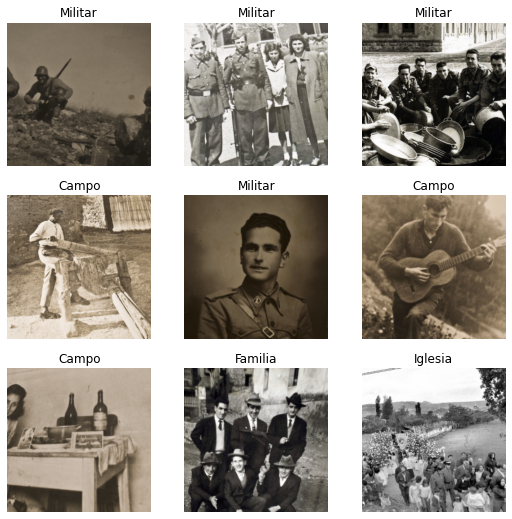

In [ ]:
dls.show_batch(max_n=9)

### 2.2. Entrenamiento del modelo

In [ ]:
learn = cnn_learner(dls,resnet18,metrics=accuracy).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


In [ ]:
learn.fine_tune(10,base_lr=1e-3)

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,2.259763,1.393098,0.462500,04:15


epoch,train_loss,valid_loss,accuracy,time
0,1.752507,1.267969,0.475000,05:21
1,1.751736,1.239919,0.500000,05:16
2,1.628010,1.186876,0.550000,05:24
3,1.520601,1.137450,0.575000,05:14
4,1.417824,1.123368,0.575000,05:24
5,1.322021,1.101972,0.562500,05:12
6,1.230831,1.084046,0.581250,05:31
7,1.175146,1.081992,0.562500,05:18
8,1.098407,1.063958,0.562500,05:17
9,1.046486,1.064375,0.568750,05:24


In [ ]:
learn.export()

In [ ]:
Path().ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

### 2.3. Estudio del modelo

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


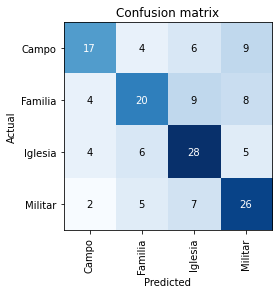

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=64)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


(#2) [2.5790247917175293,0.34756097197532654]